## Import Lib

In [1]:
# basic lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


# Machine Learning lib
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score

# text prepration lib
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec
from string import punctuation
import re

# save models
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(500)

**Read Data**

In [3]:
df = pd.read_csv("data/Job titles and industries.csv")

## EDA

In [4]:
# rename columns name to can use dot with data and column name.
df.columns = [i.strip().title().replace(" ","_") for i in [*df.columns]]
df.columns

Index(['Job_Title', 'Industry'], dtype='object')

In [5]:
# check out NAN Values in data.
df.isnull().sum()

Job_Title    0
Industry     0
dtype: int64

In [6]:
# distribution for target values.
df.Industry.value_counts()

IT             4746
Marketing      2031
Education      1435
Accountancy     374
Name: Industry, dtype: int64

In [7]:
# type of data by columns
df.dtypes

Job_Title    object
Industry     object
dtype: object

In [8]:
# change target columns to categorical data.
df.Industry = df.Industry.astype('category')

In [9]:
# reprint data type by columns after last change.
df.dtypes

Job_Title      object
Industry     category
dtype: object

In [10]:
print("Number of rows before remove duplicates : {}".format(df.shape[0]))

Number of rows before remove duplicates : 8586


In [11]:
# duplicated data size.
df.Job_Title[df.duplicated(keep=False)].count()

5710

In [12]:
# drop duplicate data.
df.drop_duplicates(keep='last',inplace=True)

In [13]:
print(f"Number of rows after remove duplicates : {df.shape[0]}")

Number of rows after remove duplicates : 3968


In [14]:
# distribution of target values (count repeted values) after drop duplication.
df.Industry.value_counts()

IT             1529
Marketing      1203
Education       973
Accountancy     263
Name: Industry, dtype: int64

In [15]:
# unique values for target column.
df.Industry.unique()

['IT', 'Marketing', 'Education', 'Accountancy']
Categories (4, object): ['Accountancy', 'Education', 'IT', 'Marketing']

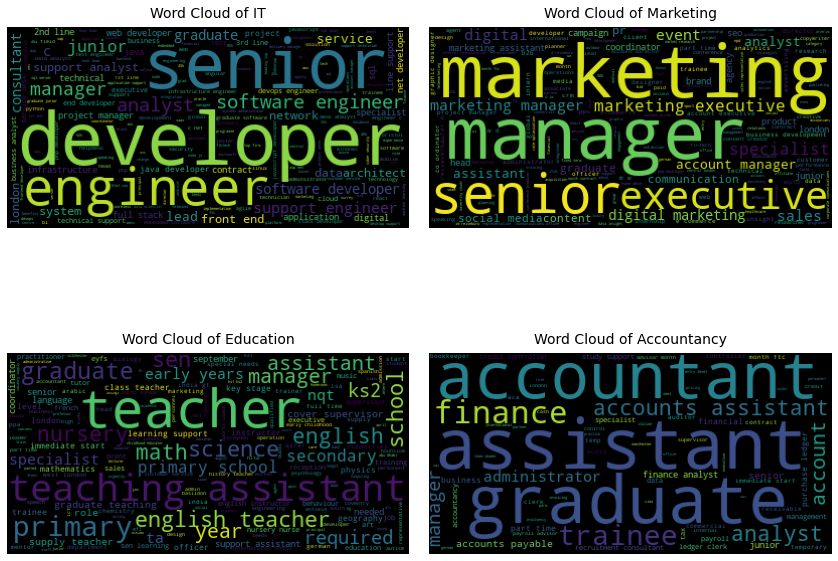

In [16]:
# plot most word repeted with every value in target columns.
fig = plt.figure(figsize=(12,14))

for job_name,index in  zip(df.Industry.unique(), range(1, 5)):
    ax = fig.add_subplot(2, 2, index)
    text = ' '.join(df.Job_Title[df.Industry==job_name].tolist())
    word_Job_Titles = WordCloud().generate(text)
    plt.imshow(word_Job_Titles)
    plt.axis('off')
    plt.title(f"Word Cloud of {job_name}", y=1.02, fontsize=14)
    plt.tight_layout(pad=2)
plt.show()

## Data Preprocessing

In [17]:
# clean data and remove speci
import preprocess_kgptalkie as ps

df.Job_Title = df.Job_Title.apply(lambda x : ps.remove_special_chars(x))

In [18]:
# --take text and preprocess 
#   1- remove stopwords [a, the, and, thus, ..etc].
#   2- punctations[,%$ .etc].
#   3- len of text more than 2.
#   4- check that word is english alpha letter.
def clean_text(text):
    """
        text: a string 
        return: cleaned string
    """
    result = []
#     regular expression that compile all english letter.
    reg = re.compile(r'[a-zA-Z]')
#     loop on string split it to many word.
    for token in simple_preprocess(text):
        # check that word is english word length is more than 2 letter,
        # not punctuation, not stopwords like [“a”, “the”, “is”, “are” and ..etc]
        if token not in STOPWORDS and token not in punctuation and  len(token) >= 3 and reg.match(token) :
            token = token.lower() 
            result.append(token)    
    return " ".join(result)

In [19]:
# preprocessing text on Job_title columns.
df.Job_Title = df.Job_Title.map(clean_text)
df.head()

,Job_Title,Industry
0,technical support helpdesk supervisor county b...,IT
2,head services,IT
3,end engineer,IT
4,network telephony controller,IT
5,privileged access management expert,IT


In [20]:
df.Industry.unique()

['IT', 'Marketing', 'Education', 'Accountancy']
Categories (4, object): ['Accountancy', 'Education', 'IT', 'Marketing']

In [21]:
label_dict = {"Accountancy":0, "Education":1, "IT":2,"Marketing":3}

In [22]:
# label encode for target columns(Industry).
Y = df.Industry.map(label_dict)

In [23]:
pd.DataFrame(Y, columns=['Y']).Y.unique()

array([], dtype=object)

In [24]:
# sample of data after preprocessing.
df.Industry.value_counts()

IT             1529
Marketing      1203
Education       973
Accountancy     263
Name: Industry, dtype: int64

In [25]:
# Voctrizer the Job_Title column (X)
from sklearn.feature_extraction.text import CountVectorizer
Tfidf_vect = CountVectorizer()
Tfidf_vect.fit(df.Job_Title)
X = Tfidf_vect.transform(df.Job_Title).toarray()

In [26]:
print("Dimension of X = ",X.shape)

Dimension of X =  (3968, 1868)


In [27]:
print(Tfidf_vect.vocabulary_)

{'technical': 1685, 'support': 1654, 'helpdesk': 783, 'supervisor': 1650, 'county': 398, 'buildings': 226, 'ayr': 142, 'soa': 1564, 'head': 773, 'services': 1542, 'end': 541, 'engineer': 546, 'network': 1149, 'telephony': 1696, 'controller': 379, 'privileged': 1324, 'access': 11, 'management': 1039, 'expert': 604, 'data': 433, 'modeller': 1108, 'php': 1265, 'web': 1815, 'developer': 463, 'based': 156, 'london': 1011, 'devops': 467, 'engineers': 550, 'global': 716, 'brand': 209, 'solution': 1575, 'architect': 96, 'ethical': 571, 'junior': 925, 'frontend': 678, 'net': 1145, 'milton': 1102, 'keynes': 940, 'scientist': 1501, 'newcastle': 1154, 'senior': 1531, 'machine': 1026, 'learning': 983, 'stack': 1606, 'oxfordshire': 1223, 'software': 1571, 'waltham': 1804, 'cross': 416, 'erp': 565, 'analyst': 67, 'unit': 1766, 'agresso': 48, 'business': 230, 'world': 1854, 'application': 84, 'cheshire': 290, 'financial': 635, 'accountancy': 14, 'trainer': 1731, 'manchester': 1047, 'remote': 1425, 'wo

**Split Data**

In [28]:
# split data to train and test.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y,test_size=0.3, random_state=24)

## Modeling

In [29]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Train Accuracy Score -> ",accuracy_score(Naive.predict(X_train), y_train)*100)
print("Naive Bayes Test Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Train Accuracy Score ->  89.52106589845157
Naive Bayes Test Accuracy Score ->  87.74139378673384


In [30]:
print(classification_report(predictions_NB, y_test))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79        79
           1       0.87      0.94      0.90       248
           2       0.91      0.90      0.90       469
           3       0.89      0.82      0.85       395

    accuracy                           0.88      1191
   macro avg       0.85      0.88      0.86      1191
weighted avg       0.88      0.88      0.88      1191



In [31]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)

prediction_svc = svc.predict(X_test)
print("SVC Test Accuracy Score -> ",accuracy_score(prediction_svc, y_test)*100)

SVC Test Accuracy Score ->  86.56591099916037


In [32]:
print(classification_report(prediction_svc, y_test))

              precision    recall  f1-score   support

           0       0.71      0.90      0.80        72
           1       0.87      0.88      0.87       265
           2       0.90      0.88      0.89       477
           3       0.86      0.84      0.85       377

    accuracy                           0.87      1191
   macro avg       0.84      0.87      0.85      1191
weighted avg       0.87      0.87      0.87      1191



## Save Model

In [33]:
pickle.dump(Tfidf_vect, open('../Job_Title_Deployment_Flask/tranform.pkl', 'wb'))
pickle.dump(Naive, open('../Job_Title_Deployment_Flask/Naive_model.pkl', 'wb'))
pickle.dump(Naive, open('../Job_Title_Deployment_Flask/SVC_model.pkl', 'wb'))

### Thanks For Read My NoteBook :)